In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score


In [2]:
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv('Data/test.csv')
df_hdb = pd.read_csv('Data/auxiliary-data/sg-hdb-block-details.csv')
df_mrt = pd.read_csv('Data/auxiliary-data/sg-mrt-stations.csv')
df_shopping = pd.read_csv('Data/auxiliary-data/sg-shopping-malls.csv')
df_hawker = pd.read_csv('Data/auxiliary-data/sg-gov-hawkers.csv')
df_primary_schools = pd.read_csv('Data/auxiliary-data/sg-primary-schools.csv')
df_secondary_schools = pd.read_csv('Data/auxiliary-data/sg-secondary-schools.csv')

In [3]:
def clean_train_test_dataframe(df, is_test=False):
    def floor_range_avg(rng):
        upper, lower = rng.split(" to ")
        upper = int(upper)
        lower = int(lower)
        return (upper + lower)/2

    df['BLOCK'] = df['BLOCK'].str.strip().str.lower()
    df['STREET'] = df['STREET'].str.strip().str.lower()

    df["ADDRESS"] = df['BLOCK'] + " " + df['STREET']

    df['FLAT_TYPE'] = df['FLAT_TYPE'].str.replace('-', ' ').str.strip().str.lower()

    df['YEAR'] = df['MONTH'].str.split('-').str[0].astype(int)
    df['MONTH'] = df['MONTH'].str.split('-').str[1].astype(int)

    df["FLOOR"] = df["FLOOR_RANGE"].apply(floor_range_avg)
    df["FLAT_AGE"] = df["YEAR"] - df["LEASE_COMMENCE_DATA"]

    df = df.drop('ECO_CATEGORY', axis=1)
    df = df.drop('FLOOR_RANGE', axis=1)
    df = df.drop('BLOCK', axis=1)
    df = df.drop('STREET', axis=1)

    if not is_test:
        df.drop_duplicates(inplace=True)

    return df

In [4]:
def clean_df_hdb(df):
    df["ADDRESS"] = df["ADDRESS"].str.strip().str.lower()
    df["BLOCK"] = df["BLOCK"].str.strip().str.lower()

    df["ADDRESS"] = df["BLOCK"] + " " + df["ADDRESS"]

    return df.drop('BLOCK', axis=1)

def remove_near_duplicate_schools(df):
    df = df.drop_duplicates(subset=['LATITUDE', 'LONGITUDE'], keep='last')
    return df

In [5]:
df_train = clean_train_test_dataframe(df_train)
df_test = clean_train_test_dataframe(df_test, is_test=True)

df_hdb = clean_df_hdb(df_hdb)

df_primary_schools = remove_near_duplicate_schools(df_primary_schools)
df_secondary_schools = remove_near_duplicate_schools(df_secondary_schools)

In [6]:
len(df_test)

50000

In [7]:
def convert_to_coordinates(df, df_coords):
    df = df.merge(
        df_coords[['ADDRESS', 'LATITUDE', 'LONGITUDE', 'MAX_FLOOR']],
        on=['ADDRESS'],
        how='left'
    )
    return df

def calculate_distance_and_metadata(feature, df_features, df_main, meta_cols=None):
    tree = BallTree(np.radians(df_features[['LATITUDE', 'LONGITUDE']].to_numpy()), metric='haversine')
    distances, indices = tree.query(np.radians(df_main[['LATITUDE', 'LONGITUDE']].to_numpy()), k=10)
    distances_km = distances * 6371

    df_main[f"DIST_AVG_{feature}"] = np.mean(distances_km, axis=1)

    if meta_cols:
        nearest_idx = indices[:, 0]
        for col in meta_cols:
            df_main[f"{feature}_{col}"] = df_features.iloc[nearest_idx][col].values



def augment_auxiliary_data(df, mrt, shopping, hawker, primary_schools, secondary_schools):
    calculate_distance_and_metadata("MRT", mrt, df, meta_cols=["STATUS"])
    calculate_distance_and_metadata("OPEN_MRT", mrt[mrt["STATUS"] == "open"], df)
    calculate_distance_and_metadata("SHOPPING_MALL", shopping, df)
    calculate_distance_and_metadata(
        "HAWKER_CENTRE", hawker, df,
        meta_cols=["TYPE", "OWNER", "NUMBER_OF_STALLS"]
    )
    calculate_distance_and_metadata("PRIMARY_SCHOOL", primary_schools, df)
    calculate_distance_and_metadata("SECONDARY_SCHOOL", secondary_schools, df)
    return df


In [8]:
df_train = convert_to_coordinates(df_train, df_hdb)
df_test = convert_to_coordinates(df_test, df_hdb)

df_train = augment_auxiliary_data(df_train, df_mrt, df_shopping, df_hawker, df_primary_schools, df_secondary_schools)
df_test = augment_auxiliary_data(df_test, df_mrt, df_shopping, df_hawker, df_primary_schools, df_secondary_schools)

In [9]:
len(df_test)

50000

In [10]:
list(df_train)

['MONTH',
 'TOWN',
 'FLAT_TYPE',
 'FLOOR_AREA_SQM',
 'FLAT_MODEL',
 'LEASE_COMMENCE_DATA',
 'RESALE_PRICE',
 'ADDRESS',
 'YEAR',
 'FLOOR',
 'FLAT_AGE',
 'LATITUDE',
 'LONGITUDE',
 'MAX_FLOOR',
 'DIST_AVG_MRT',
 'MRT_STATUS',
 'DIST_AVG_OPEN_MRT',
 'DIST_AVG_SHOPPING_MALL',
 'DIST_AVG_HAWKER_CENTRE',
 'HAWKER_CENTRE_TYPE',
 'HAWKER_CENTRE_OWNER',
 'HAWKER_CENTRE_NUMBER_OF_STALLS',
 'DIST_AVG_PRIMARY_SCHOOL',
 'DIST_AVG_SECONDARY_SCHOOL']

In [11]:
def plot_univariate_categorical_grid(df, cat_cols):
    n = len(cat_cols)
    ncols = 3
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 10*nrows))
    axes = axes.flatten()

    for i, feature_name in enumerate(cat_cols):
        ax = axes[i]
        order = df[feature_name].value_counts().index

        sns.countplot(x=feature_name, data=df, order=order, ax=ax)

        ax.set_title(f'{feature_name} (Unique: {df[feature_name].nunique()})', fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=90)

        total = len(df)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percent = 100 * height / total
                ax.annotate(
                    f'{int(height)}\n({percent:.3f}%)',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=8,
                    xytext=(0, 3),
                    textcoords='offset points'
                )

        summary_text = (
            f'Unique: {df[feature_name].nunique()}\n'
            f'Top: {df[feature_name].mode()[0]}\n'
            f'Mode %: {100 * df[feature_name].value_counts(normalize=True).iloc[0]:.1f}%'
        )
        ax.text(
            0.98, 0.98, summary_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
        )

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



# Model Selection

In [12]:
list(set(df_train.select_dtypes(include=['number'])).difference(set(["RESALE_PRICE"])))

['MAX_FLOOR',
 'DIST_AVG_PRIMARY_SCHOOL',
 'MONTH',
 'LONGITUDE',
 'LEASE_COMMENCE_DATA',
 'FLOOR_AREA_SQM',
 'DIST_AVG_SECONDARY_SCHOOL',
 'DIST_AVG_MRT',
 'LATITUDE',
 'YEAR',
 'DIST_AVG_OPEN_MRT',
 'DIST_AVG_SHOPPING_MALL',
 'HAWKER_CENTRE_NUMBER_OF_STALLS',
 'FLAT_AGE',
 'FLOOR',
 'DIST_AVG_HAWKER_CENTRE']

In [13]:
list(set(df_train).difference(set(df_train.select_dtypes(include=['number']))))

['MRT_STATUS',
 'HAWKER_CENTRE_TYPE',
 'FLAT_MODEL',
 'ADDRESS',
 'HAWKER_CENTRE_OWNER',
 'TOWN',
 'FLAT_TYPE']

In [14]:
target = 'RESALE_PRICE'

num_features = [
     'DIST_AVG_MRT',
     'DIST_AVG_SHOPPING_MALL',
     'DIST_AVG_PRIMARY_SCHOOL',
     'DIST_AVG_HAWKER_CENTRE',
     'DIST_AVG_SECONDARY_SCHOOL',
     'HAWKER_CENTRE_NUMBER_OF_STALLS',
     'LATITUDE',
     'LONGITUDE',
     'MAX_FLOOR',
     'FLOOR',
     'FLAT_AGE',
     'YEAR',
     'FLOOR_AREA_SQM',
     'MONTH'
]

cat_features = [
    'HAWKER_CENTRE_OWNER',
     'FLAT_TYPE',
     'HAWKER_CENTRE_TYPE',
     'FLAT_MODEL',
     'MRT_STATUS',
     'TOWN'
]

features = cat_features + num_features

In [15]:
X = df_train[features].copy()
y = df_train[target].copy()

In [16]:
for col in cat_features:
     X[col] = X[col].astype("category")

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

best_params = {
    'subsample': 1.0,
    'reg_lambda': 3,
    'reg_alpha': 0,
    'min_child_weight': 7,
    'max_depth': 6,
    'learning_rate': 0.05,
    'gamma': 0.2,
    'colsample_bytree': 0.5
}

model = XGBRegressor(
    **best_params,
    n_estimators=2000,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    tree_method='hist',
    verbosity=0,
    enable_categorical=True
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

cv_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf, n_jobs=-1, verbose=1)

mean_rmse = -np.mean(cv_scores)
std_rmse = np.std(cv_scores)

print("\n5-Fold Cross-Validation Results:")
print(f"RMSE scores (per fold): {-cv_scores}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Std RMSE: {std_rmse:.4f}\n")

final_xgb = XGBRegressor(
    **best_params,
    n_estimators=2000,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    early_stopping_rounds=100,
    tree_method='hist',
    enable_categorical=True,
    verbosity=1
)

final_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

y_pred = final_xgb.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("\nFinal Model Evaluation (Validation Set):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.4s finished



5-Fold Cross-Validation Results:
RMSE scores (per fold): [25213.37308793 25342.93331906 25130.31048404 25362.90972979
 25301.45129615]
Mean RMSE: 25270.1956
Std RMSE: 86.7874

[0]	validation_0-rmse:176581.64048	validation_1-rmse:174864.47113
[50]	validation_0-rmse:56831.85766	validation_1-rmse:56502.00567
[100]	validation_0-rmse:40124.85892	validation_1-rmse:40139.40997
[150]	validation_0-rmse:35555.65697	validation_1-rmse:35716.55128
[200]	validation_0-rmse:32957.62539	validation_1-rmse:33254.91535
[250]	validation_0-rmse:31228.34140	validation_1-rmse:31649.56698
[300]	validation_0-rmse:29996.58736	validation_1-rmse:30514.67934
[350]	validation_0-rmse:28859.39465	validation_1-rmse:29484.97200
[400]	validation_0-rmse:27976.54807	validation_1-rmse:28689.37087
[450]	validation_0-rmse:27269.90204	validation_1-rmse:28083.32225
[500]	validation_0-rmse:26725.34311	validation_1-rmse:27629.86648
[550]	validation_0-rmse:26284.15509	validation_1-rmse:27276.14443
[600]	validation_0-rmse:25867.21

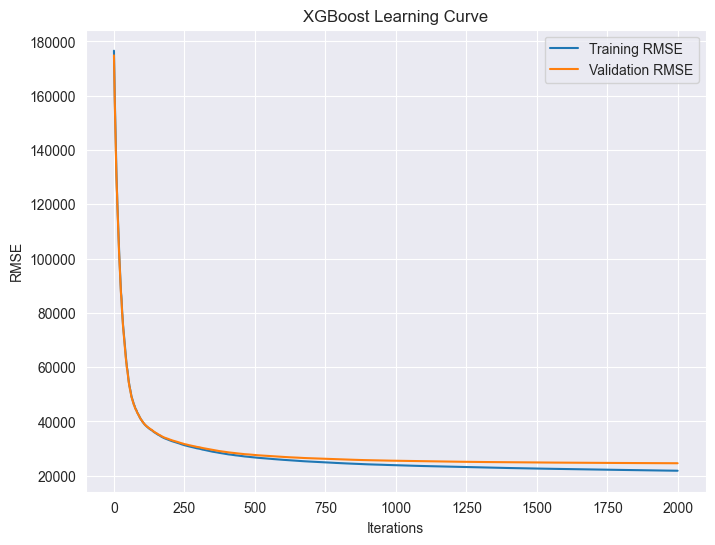

In [19]:
evals_result = final_xgb.evals_result_
train_rmse = evals_result['validation_0']['rmse']
val_rmse = evals_result['validation_1']['rmse']

plt.figure(figsize=(8, 6))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
X_test = df_test[features].copy()

for col in cat_features:
     X_test[col] = X_test[col].astype("category")

y_test_pred = final_xgb.predict(X_test)

submission = pd.DataFrame({
    "Id": df_test.index,
    "Predicted_Resale_Price": y_test_pred
})

submission.to_csv("submission_xgb.csv", index=False)

In [21]:
from catboost import CatBoostRegressor, Pool, cv

train_pool_full = Pool(X, y, cat_features=cat_features)

params = {
    'subsample': 0.7,
    'iterations': 2000,
    'learning_rate': 0.05,
    'depth': 10,
    'l2_leaf_reg': 5,
    'colsample_bylevel': 1.0,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'early_stopping_rounds': 100,
    'task_type': 'CPU',
    'devices': '0'
}

# Perform CV
cv_data = cv(
    params=params,
    pool=train_pool_full,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    verbose=False,
    plot=False
)

mean_rmse = cv_data['test-RMSE-mean'].iloc[-1]
std_rmse = cv_data['test-RMSE-std'].iloc[-1]

print("\n5-Fold Cross-Validation Results:")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Std RMSE: {std_rmse:.4f}\n")


train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

final_cat = CatBoostRegressor(**params, verbose=100)

final_cat.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)

val_preds = final_cat.predict(val_pool)

mse = mean_squared_error(y_val, val_preds)
mae = mean_absolute_error(y_val, val_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, val_preds)

print("\nFinal Model Evaluation (Validation Set):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Training on fold [0/5]

bestTest = 25455.70056
bestIteration = 1999

Training on fold [1/5]

bestTest = 25023.86349
bestIteration = 1999

Training on fold [2/5]

bestTest = 25192.82504
bestIteration = 1999

Training on fold [3/5]

bestTest = 25261.89175
bestIteration = 1999

Training on fold [4/5]

bestTest = 24945.04616
bestIteration = 1998


5-Fold Cross-Validation Results:
Mean RMSE: 25175.8665
Std RMSE: 201.4792

0:	learn: 176079.1263615	test: 174382.4800391	best: 174382.4800391 (0)	total: 88.4ms	remaining: 2m 56s
100:	learn: 40857.7729874	test: 40682.7985625	best: 40682.7985625 (100)	total: 9.96s	remaining: 3m 7s
200:	learn: 33568.7957188	test: 33718.0747387	best: 33718.0747387 (200)	total: 19.1s	remaining: 2m 51s
300:	learn: 30217.1196745	test: 30556.0521903	best: 30556.0521903 (300)	total: 27.2s	remaining: 2m 33s
400:	learn: 28127.7402304	test: 28702.0531062	best: 28702.0531062 (400)	total: 35.1s	remaining: 2m 19s
500:	learn: 26766.2837663	test: 27545.4331140	best: 27545.4331140

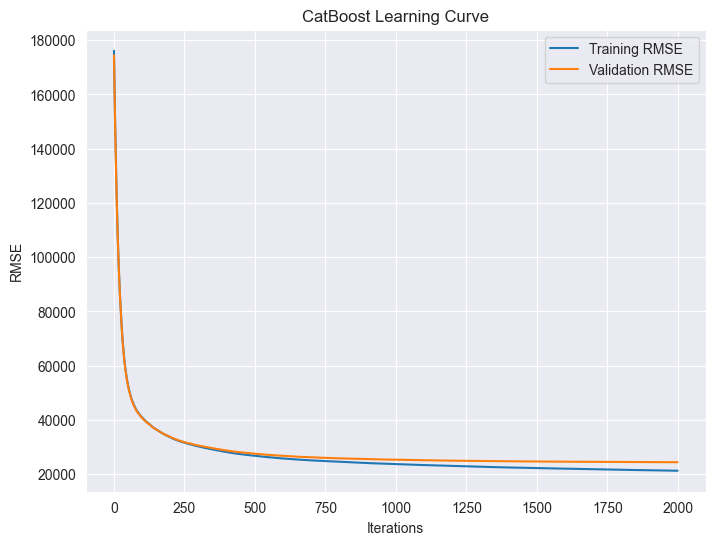

In [22]:
import matplotlib.pyplot as plt

evals_result = final_cat.evals_result_
train_rmse = evals_result['learn']['RMSE']
val_rmse = evals_result['validation']['RMSE']

plt.figure(figsize=(8, 6))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
from lightgbm import LGBMRegressor

best_params = {
    'subsample': 0.8,
    'reg_lambda': 7,
    'reg_alpha': 0.1,
    'num_leaves': 31,
    'min_child_weight': 7,
    'max_depth': 10,
    'learning_rate': 0.1,
    'colsample_bytree':0.5
}

model = LGBMRegressor(
    **best_params,
    n_estimators=2000,
    objective='regression',
    metric='rmse',
    random_state=42,
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

cv_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf, n_jobs=-1, verbose=1)

mean_rmse = -np.mean(cv_scores)
std_rmse = np.std(cv_scores)

print("\n5-Fold Cross-Validation Results:")
print(f"RMSE scores (per fold): {-cv_scores}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Std RMSE: {std_rmse:.4f}\n")


final_light = LGBMRegressor(
    **best_params,
    n_estimators=2000,
    objective='regression',
    metric='rmse',
    random_state=42,
)

final_light.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse',
)

y_pred = final_light.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("\nFinal Model Evaluation (Validation Set):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 129972, number of used features: 20
[LightGBM] [Info] Start training from score 519084.642397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 129971, number of used features: 20
[LightGBM] [Info] Start training from score 519143.493631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished



5-Fold Cross-Validation Results:
RMSE scores (per fold): [25224.38002763 25298.99295783 25099.82163991 25487.64717989
 25254.66314715]
Mean RMSE: 25273.1010
Std RMSE: 126.0475

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 146217, number of used features: 20
[LightGBM] [Info] Start training from score 518926.422154

Final Model Evaluation (Validation Set):
Mean Squared Error: 601073612.8489
Mean Absolute Error: 17770.1960
Root Mean Squared Error: 24516.8027
R² Score: 0.9818


In [25]:
train_rmse[1999]

np.float64(21085.382938702936)

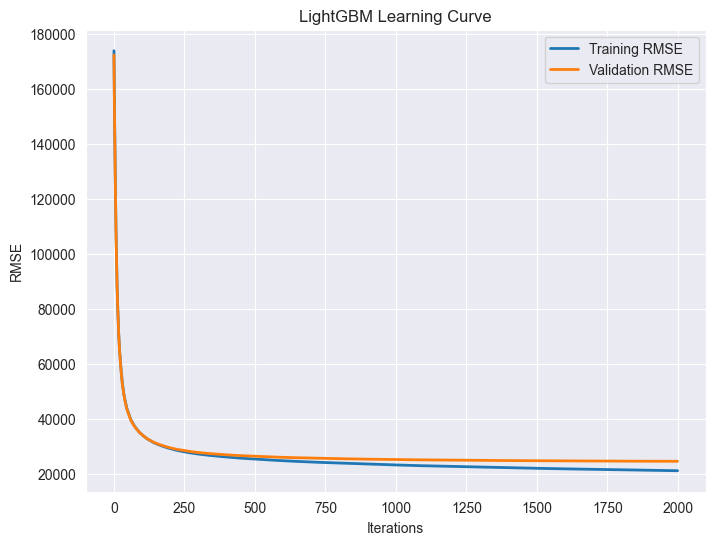

In [24]:
import matplotlib.pyplot as plt

evals_result = final_light.evals_result_

train_rmse = evals_result['training']['rmse']
val_rmse = evals_result['valid_1']['rmse']

plt.figure(figsize=(8, 6))
plt.plot(train_rmse, label='Training RMSE', linewidth=2)
plt.plot(val_rmse, label='Validation RMSE', linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Learning Curve')
plt.legend()
plt.grid(True)
plt.show()
